In [4]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn import linear_model

In [5]:
def generate_cycle(A, period,phase, adding):
    for index, p in enumerate(period):
        if p < 0:
            period[index] = -p
    def sin_function(x, A, T):
        return A * np.sin( 2 * np.pi / T * (x + phase)) + adding
    total_step = 1000 # 100 T
    total_distance = 0
    cycle = []
    for step in range(total_step):
        half_period = period[step] / 2
        if(step % 2 == 0):
            sub_step_list = np.linspace(0, half_period, 100).tolist()
            for sub_step in sub_step_list:
                cycle.append(sin_function(sub_step, A[step], period[step]))
            total_distance += half_period
        else:
            sub_step_list = np.linspace(half_period, period[step], 100).tolist()
            for sub_step in sub_step_list:
                cycle.append(sin_function(sub_step, A[step], period[step]))
            total_distance += half_period
    return cycle, total_distance

soil_moisture = []
for month in range(1, 10):
    f = nc.Dataset("../Data/2017_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20170"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    soil_moisture.append(sm[0][193][249])
for month in range(10, 13):
    f = nc.Dataset("../Data/2017_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-2017"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    soil_moisture.append(sm[0][193][249])
for month in range(1, 10):
    f = nc.Dataset("../Data/2018_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20180"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    processed_data = 0
    if(sm[0][193][249] == -9999.):
        _ = 0
        for j in range (-15, 15):
            if(sm[0][193][249+j] != -9999.):
                if(_ == 0):
                    _ = sm[0][193][249+j]
                else:
                    _ = (sm[0][193][249+j] + _)/2
        processed_data = _
    if(sm[0][193][249] != -9999.):
        soil_moisture.append(sm[0][193][249])
    else:
        soil_moisture.append(processed_data)
for month in range(10, 13):
    f = nc.Dataset("../Data/2018_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-2018"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    processed_data = 0
    if(sm[0][193][249] == -9999.):
        _ = 0
        for j in range (-15, 15):
            if(sm[0][193][249+j] != -9999.):
                if(_ == 0):
                    _ = sm[0][193][249+j]
                else:
                    _ = (sm[0][193][249+j] + _)/2
        processed_data = _
    if(sm[0][193][249] != -9999.):
        soil_moisture.append(sm[0][193][249])
    else:
        soil_moisture.append(processed_data)
for index, data in enumerate(soil_moisture):
    if(data == 0):
        data = (soil_moisture[index-1] + soil_moisture[index+1])/2
        soil_moisture[index] = data
air_pressure_california = pd.DataFrame(pd.read_csv("../Data/California_data/AirPressure.csv"))
air_pressure_list = air_pressure_california.values[0].tolist() + air_pressure_california.values[1].tolist()
rainfall_california = pd.DataFrame(pd.read_csv("../Data/California_data/ObservedRainfall.csv"))
rainfall_list = rainfall_california.values[0].tolist() + rainfall_california.values[1].tolist()
temperature_california = pd.DataFrame(pd.read_csv("../Data/California_data/Temperature.csv"))
temperature_list = temperature_california.values[0].tolist() + temperature_california.values[1].tolist()
rainfall_list[11] = (rainfall_list[12] + rainfall_list[10])/2
rainfall_list[13] = (rainfall_list[12] + rainfall_list[14])/1.5
rainfall_list[-1] = (rainfall_list[-2])*1.5
rainfall_list[0], rainfall_list[1] = rainfall_list[1], rainfall_list[0]
rainfall_list[0], rainfall_list[2] = rainfall_list[2], rainfall_list[0]
rainfall_list[3] = (rainfall_list[2] + rainfall_list[4])/2
for i in range(4, 11):
    rainfall_list[i] = (rainfall_list[i-1] + rainfall_list[i+1])/2 
for i in range(16, 22):
    rainfall_list[i] = (rainfall_list[i-1] + rainfall_list[i+1])/2 
rainfall_list = [i/3 for i in rainfall_list]
air_pressure_list, rainfall_list, temperature_list = np.array(air_pressure_list), np.array(rainfall_list), np.array(temperature_list)
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
model = linear_model.LinearRegression()
df_train = pd.DataFrame({'rainfall': rainfall_list , 'temperature': np.log(temperature_list), 'soil_moisture': soil_moisture})
model.fit(df_train[['rainfall']], df_train['soil_moisture'])
A = np.random.normal(12, 15, 5000)
period = np.random.normal(12, 15, 5000)
period = [-p for p in period if p < 0] + [p for p in period if p > 0]
adding = 70
temp_cycle,temp_distance = generate_cycle(A, period, 0, adding)
A = np.random.normal(5/3, 5, 5000)
period = np.random.normal(12, 15, 5000)
period = [-p for p in period if p < 0] + [p for p in period if p > 0]
adding = 0
rainfall_cycle,rainfall_distance = generate_cycle(A, period, np.pi/2 ,adding)
x= np.arange(0, 5000, 0.05)
temp_cycle, rainfall_cycle = np.array(temp_cycle), np.array(rainfall_cycle)
df_predict = pd.DataFrame({'rainfall': rainfall_cycle})
moisture_predicted_data = model.predict(df_predict)
moisture_predicted_data = [round(i, 3) for i in moisture_predicted_data]
plant_info = pd.read_csv("../Data/plant_info/PlantInfo.csv")
plant_data_frame = pd.DataFrame(plant_info)
plants_moisture = plant_data_frame["Suitable Moisture(inch/year)"].values.tolist()
plants_min_rainfall = [float(moisture.split(" ")[0]) for moisture in plants_moisture]
plants_max_rainfall= [float(moisture.split(" ")[1]) for moisture in plants_moisture]
species_min_moisture = []
species_max_moisture = []
for specie_min_moisture in plants_min_rainfall:
    specie_min_rainfall = [specie_min_moisture] * len(rainfall_cycle)
    specie_min_rainfall = np.array(specie_min_rainfall)/12
    specie_min_moisture = model.predict(pd.DataFrame({'rainfall': specie_min_rainfall}))
    species_min_moisture.append(specie_min_moisture)
for specie_max_moisture in plants_max_rainfall:
    specie_max_rainfall = [specie_max_moisture] * len(rainfall_cycle)
    specie_max_rainfall = np.array(specie_max_rainfall)/12
    specie_max_moisture = model.predict(pd.DataFrame({'rainfall': specie_max_rainfall}))
    species_max_moisture.append(specie_max_moisture)
species_min_moisture = [i[0] for i in species_min_moisture]
species_max_moisture = [i[0] for i in species_max_moisture]
species_min_moisture = [round(i, 2) for i in species_min_moisture]
species_max_moisture = [round(i, 2) for i in species_max_moisture]
def normal_distribution(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-1 / 2 * ((x - mu) / sigma) ** 2)

cs_x_distribution = np.arange(0.03, 0.371, 0.001)
cs_y_distribution = normal_distribution(cs_x_distribution, 0.2, 0.1)
cs_y_distribution = [(i-min(cs_y_distribution)) / (max(cs_y_distribution) - min(cs_y_distribution))  for i in cs_y_distribution]
cs_x_distribution = [(round(i, 3)) for i in cs_x_distribution]
cp_x_distribution = np.arange(0.03, 0.371, 0.001)
cp_y_distribution = normal_distribution(cp_x_distribution, 0.195, 0.1)
cp_y_distribution = [(i-min(cp_y_distribution)) / (max(cp_y_distribution) - min(cp_y_distribution))  for i in cp_y_distribution]
cp_x_distribution = [(round(i, 3)) for i in cp_x_distribution]
R_x_distribution = np.arange(0.05, 0.801, 0.001)
R_y_distribution = normal_distribution(R_x_distribution, 0.325, 0.2)
R_y_distribution = [(i-min(R_y_distribution)) / (max(R_y_distribution) - min(R_y_distribution))  for i in R_y_distribution]
R_x_distribution = [(round(i, 3)) for i in R_x_distribution]
BG_x_distribution = np.arange(0.07, 0.311, 0.001)
BG_y_distribution = normal_distribution(BG_x_distribution, 0.19, 0.07)
BG_y_distribution = [(i-min(BG_y_distribution)) / (max(BG_y_distribution) - min(BG_y_distribution))  for i in BG_y_distribution]
BG_x_distribution = [(round(i, 3)) for i in BG_x_distribution]
PR_x_distribution = np.arange(0.1, 0.451, 0.001)
PR_y_distribution = normal_distribution(PR_x_distribution, 0.275, 0.1)
PR_y_distribution = [(i-min(PR_y_distribution)) / (max(PR_y_distribution) - min(PR_y_distribution))  for i in PR_y_distribution]
PR_x_distribution = [(round(i, 3)) for i in PR_x_distribution]
DW_x_distribution = np.arange(0.03, 0.371, 0.001)
DW_y_distribution = normal_distribution(DW_x_distribution, 0.205, 0.1)
DW_y_distribution = [(i-min(DW_y_distribution)) / (max(DW_y_distribution) - min(DW_y_distribution))  for i in DW_y_distribution]
DW_x_distribution = [(round(i, 3)) for i in DW_x_distribution]
RW_x_distribution = np.arange(0.02, 1.21, 0.001)
RW_y_distribution = normal_distribution(RW_x_distribution, 0.415, 0.3)
RW_y_distribution = [(i-min(RW_y_distribution)) / (max(RW_y_distribution) - min(RW_y_distribution))  for i in RW_y_distribution]
RW_x_distribution = [(round(i, 3)) for i in RW_x_distribution]
x_ranges = [[0.03, 0.37], [0.03, 0.37], [0.05, 0.8], [0.07, 0.31], [0.1, 0.45], [0.03, 0.37], [0.02, 1.2]]

In [4]:
def softmax(x):
    return np.exp(np.array(x)) / np.sum(np.exp(x), axis=0).tolist()

def differential_function(variable_list, timespan, num_of_species, x_range_list, distribution_list ,growth_rate_list, moisture, N_list, competition_matrix_list, cooperation_matrix_list):
    polynomials = []
    real_growth_rate = []
    percentage = []
    for i in range(num_of_species):
        if (moisture>= x_range_list[i][0]) and (moisture<= x_range_list[i][1]):
            percentage.append(distribution_list[i][moisture])
        else:
            percentage.append(0)
    real_growth_rate = [i * j for i, j in zip(growth_rate_list, percentage)]
    compete_list = []
    coop_list = []
    for i in range(num_of_species):
        compete_list.append(sum(1/N_list[j] * competition_matrix_list[i][j] * variable_list[j] for j in range(num_of_species) if j != i))
        coop_list.append(sum(1/N_list[j] * cooperation_matrix_list[i][j] * variable_list[j] for j in range(num_of_species) if j != i))
    # compete_list, coop_list = softmax(compete_list), softmax(coop_list)
    for i in range(num_of_species):
        poly = real_growth_rate[i] * variable_list[i] * (1 - variable_list[i]/N_list[i] - compete_list[i] + coop_list[i])
        polynomials.append(poly)
    return np.array(polynomials)

time = np.arange(0, 2000, 0.05)
timespan = np.arange(0, 0.05, 0.01)
variable_list = [10, 10, 10, 10, 10, 10, 10]
N_list = [100,100,100,200,200,50,50]
num_of_species = 7
x_range_list = x_ranges
distribution_list=[]
distribution_list.append(dict(zip(cs_x_distribution, cs_y_distribution)))
distribution_list.append(dict(zip(cp_x_distribution, cp_y_distribution)))
distribution_list.append(dict(zip(R_x_distribution, R_y_distribution)))
distribution_list.append(dict(zip(BG_x_distribution, BG_y_distribution)))
distribution_list.append(dict(zip(PR_x_distribution, PR_y_distribution)))
distribution_list.append(dict(zip(DW_x_distribution, DW_y_distribution)))
distribution_list.append(dict(zip(RW_x_distribution, RW_y_distribution)))
growth_rate_list = plant_info['Growth Rate'].values.tolist()
competition_matrix = pd.read_csv("../Data/judge_matrix/Competition.csv")
competition_matrix_list = []
for value in competition_matrix.values:
    competition_matrix_list.append(value.tolist()[1:])
cooperation_matrix = pd.read_csv("../Data/judge_matrix/Cooperation.csv")
cooperation_matrix_list = []
for value in cooperation_matrix.values:
    cooperation_matrix_list.append(value.tolist()[1:])
solution_list = []
for timestep in range(len(time)):
    moisture = moisture_predicted_data[timestep]
    solution = odeint(differential_function, variable_list, timespan, args=(num_of_species, x_range_list, distribution_list, growth_rate_list, moisture, N_list, competition_matrix_list, cooperation_matrix_list))
    solution = solution[-1]
    variable_list = solution.tolist()
    solution_list.append(solution)
cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = [i[0] for i in solution_list], [i[1] for i in solution_list], [i[2] for i in solution_list], [i[3] for i in solution_list], [i[4] for i in solution_list], [i[5] for i in solution_list], [i[6] for i in solution_list]

In [5]:
l = [1,2,3,4,5]
print([l[1]] + [l[2]] )

[2, 3]


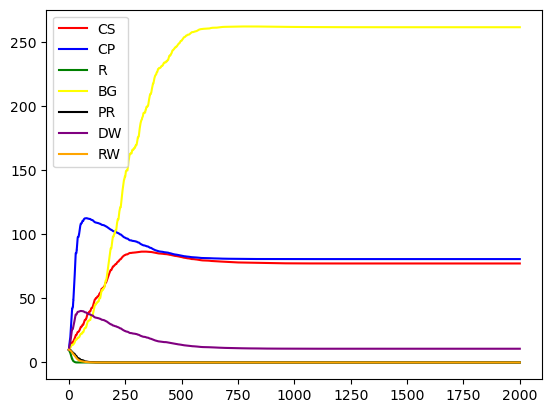

In [6]:
plt.plot(time, cs_trend, color='red', label='CS')
plt.plot(time, cp_trend, color='blue', label='CP')
plt.plot(time, R_trend, color='green', label='R')
plt.plot(time, BG_trend, color='yellow', label='BG')
plt.plot(time, PR_trend, color='black', label='PR')
plt.plot(time, DW_trend, color='purple', label='DW')
plt.plot(time, RW_trend, color='orange', label='RW')
plt.legend()
plt.show()

In [9]:


def differential_function(variable_list, timespan, num_of_species, x_range_list, distribution_list ,growth_rate_list, moisture, N_list, competition_matrix_list, cooperation_matrix_list):
    polynomials = []
    real_growth_rate = []
    percentage = []
    for i in range(num_of_species):
        if (moisture>= x_range_list[i][0]) and (moisture<= x_range_list[i][1]):
            percentage.append(distribution_list[i][moisture])
        else:
            percentage.append(0)
    real_growth_rate = [i * j for i, j in zip(growth_rate_list, percentage)]
    compete_list = []
    coop_list = []
    for i in range(num_of_species):
        compete_list.append(sum(1/N_list[j] * competition_matrix_list[i][j] * variable_list[j] for j in range(num_of_species) if j != i))
        coop_list.append(sum(1/N_list[j] * cooperation_matrix_list[i][j] * variable_list[j] for j in range(num_of_species) if j != i))
    # compete_list, coop_list = softmax(compete_list), softmax(coop_list)
    for i in range(num_of_species):
        poly = real_growth_rate[i] * variable_list[i] * (1 - variable_list[i]/N_list[i] - compete_list[i] + coop_list[i])
        polynomials.append(poly)
    return np.array(polynomials)

def montecarlosimulation(indices):
    N_list = []
    for i in indices:
        if(i == 0 or i == 1 or i == 2):
            N_list.append(100)
        elif(i == 3 or i == 4):
            N_list.append(200)
        elif(i == 5 or i == 6):
            N_list.append(50)

    time = np.arange(0, 2000, 0.05)
    timespan = np.arange(0, 0.05, 0.01)
    variable_list = [10] * len(indices)
    num_of_species = len(indices)
    x_range_list = [x_ranges[i] for i in indices]
    all_distribution_list = [dict(zip(cs_x_distribution, cs_y_distribution)), dict(zip(cp_x_distribution, cp_y_distribution)), dict(zip(R_x_distribution, R_y_distribution)), dict(zip(BG_x_distribution, BG_y_distribution)), dict(zip(PR_x_distribution, PR_y_distribution)), dict(zip(DW_x_distribution, DW_y_distribution)), dict(zip(RW_x_distribution, RW_y_distribution))]
    distribution_list=[all_distribution_list[i] for i in indices]
    growth_rate_list = plant_info['Growth Rate'].values.tolist()
    growth_rate_list = [i for j, i in enumerate(growth_rate_list) if j in indices]
    competition_matrix = pd.read_csv("../Data/judge_matrix/Competition.csv")
    competition_matrix_list = []
    for index, value in enumerate(competition_matrix.values):
        if(index not in indices):
            continue
        value_list = [value.tolist()[1:][i] for i in range(len(value.tolist()[1:])) if i in indices]
        competition_matrix_list.append(value_list)
    cooperation_matrix = pd.read_csv("../Data/judge_matrix/Cooperation.csv")
    cooperation_matrix_list = []
    for index, value in enumerate(cooperation_matrix.values):
        if(index not in indices):
            continue
        value_list = [value.tolist()[1:][i] for i in range(len(value.tolist()[1:])) if i in indices]
        cooperation_matrix_list.append(value_list)
    solution_list = []
    for timestep in range(len(time)):
        moisture = moisture_predicted_data[timestep]
        solution = odeint(differential_function, variable_list, timespan, args=(num_of_species, x_range_list, distribution_list, growth_rate_list, moisture, N_list, competition_matrix_list, cooperation_matrix_list))
        solution = solution[-1]
        variable_list = solution.tolist()
        solution_list.append(solution)
    # cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = [i[0] for i in solution_list], [i[1] for i in solution_list], [i[2] for i in solution_list], [i[3] for i in solution_list], [i[4] for i in solution_list], [i[5] for i in solution_list], [i[6] for i in solution_list]
    species_solution = []
    for i in range(len(indices)):
        specie_solution = [j[i] for j in solution_list]
        species_solution.append(specie_solution)
    overflow = 0
    for i in range(len(indices)):
        if(species_solution[i][-1]/N_list[i] > 1):
            overflow += species_solution[i][-1]/N_list[i] - 1
    min_time_list = []
    idx_list = []
    for i in range(len(indices)):
        flag = True
        for idx, j in enumerate(species_solution[i]):
            if(abs(species_solution[i][idx] - species_solution[i][idx-100]) < 1e-1 and flag):
                min_time_list.append(plant_info['PLANT'][indices[i]])
                idx_list.append(time[idx])
                flag = False
    average_population = 0
    num_non_extinct = 0
    for i in range(len(indices)):
        if(species_solution[i][-1] > 1e-1):
            average_population += species_solution[i][-1]
            num_non_extinct += 1
    return overflow/len(indices), max(idx_list), average_population/ num_non_extinct

In [10]:
print(np.exp([1,2]))

[2.71828183 7.3890561 ]


In [12]:
import random
used_indices_list = []
overflow_list = []
equi_list = []
aver_population_list = []
while(len(used_indices_list) < 120):
    indice_length = random.randint(1, 7)
    indices = []
    while (len(indices) < indice_length):
        indice = random.randint(0, 6)
        if(indice not in indices):
            indices.append(indice)
    indices = sorted(indices)
    if(indices not in used_indices_list):
        overflow, eqil_time, aver_population = montecarlosimulation(indices)
        used_indices_list.append(indices)
        overflow_list.append(overflow)
        equi_list.append(eqil_time)
        aver_population_list.append(aver_population)

# montecarlosimulation(indices)

KeyboardInterrupt: 

In [ ]:
import statistics
popu_list, of_list, ste_list = [(i-min(aver_population_list))/ (max(aver_population_list)-min(aver_population_list)) for i in aver_population_list], [(i-min(overflow_list))/ (max(overflow_list)-min(overflow_list)) for i in overflow_list], [(max(equi_list)-i)/ (max(equi_list)-min(equi_list)) for i in equi_list]
one_index_list = [i for i in range(len(used_indices_list)) if len(used_indices_list[i]) == 1]
two_index_list = [i for i in range(len(used_indices_list)) if len(used_indices_list[i]) == 2]
three_index_list = [i for i in range(len(used_indices_list)) if len(used_indices_list[i]) == 3]
four_index_list = [i for i in range(len(used_indices_list)) if len(used_indices_list[i]) == 4]
five_index_list = [i for i in range(len(used_indices_list)) if len(used_indices_list[i]) == 5]
six_index_list = [i for i in range(len(used_indices_list)) if len(used_indices_list[i]) == 6]
seven_index_list = [i for i in range(len(used_indices_list)) if len(used_indices_list[i]) == 7]
benefit_list = []
benefit_list.append([popu_list[i]*2 + of_list[i]*4 + ste_list[i] for i in one_index_list])
benefit_list.append([popu_list[i]*2 + of_list[i]*4 + ste_list[i] for i in two_index_list])
benefit_list.append([popu_list[i]*2 + of_list[i]*4 + ste_list[i] for i in three_index_list])
benefit_list.append([popu_list[i]*2 + of_list[i]*4 + ste_list[i] for i in four_index_list])
benefit_list.append([popu_list[i]*2 + of_list[i]*4 + ste_list[i] for i in five_index_list])
benefit_list.append([popu_list[i]*2 + of_list[i]*4 + ste_list[i] for i in six_index_list])
benefit_list.append([popu_list[i]*2 + of_list[i]*4 + ste_list[i] for i in seven_index_list])
benefit_base = statistics.median(benefit_list[0])
plt.title('Benefit score of different number of species')
plt.xlabel('Combinations of species')
plt.ylabel('Benefit score')
for i in range(1,7):
    plt.plot(np.arange(0, len(benefit_list[i]), 1), benefit_list[i], label = str(i+1) + ' species')
plt.plot(np.arange(0, 30, 1), [benefit_base for i in range(30)])
for i in range(0,7):
    print(len([j for j in benefit_list[i] if j >= benefit_base])/len(benefit_list[i]))
plt.legend()
plt.show()
print(statistics.median(benefit_list[0]))

NameError: name 'aver_population_list' is not defined

In [ ]:
below_base_indices_list = []


for i in range(0, len(benefit_list[0])):
    if(benefit_list[0][i] >= benefit_base):
        below_base_indices_list.append(used_indices_list[one_index_list[i]])
for i in range(0, len(benefit_list[1])):
    if(benefit_list[1][i] >= benefit_base):
        below_base_indices_list.append(used_indices_list[two_index_list[i]])
for i in range(0, len(benefit_list[2])):
    if(benefit_list[2][i] >= benefit_base):
        below_base_indices_list.append(used_indices_list[three_index_list[i]])
for i in range(0, len(benefit_list[3])):
    if(benefit_list[3][i] >= benefit_base):
        below_base_indices_list.append(used_indices_list[four_index_list[i]])
for i in range(0, len(benefit_list[4])):
    if(benefit_list[4][i] >= benefit_base):
        below_base_indices_list.append(used_indices_list[five_index_list[i]])
for i in range(0, len(benefit_list[5])):
    if(benefit_list[5][i] >= benefit_base):
        below_base_indices_list.append(used_indices_list[six_index_list[i]])
for i in range(0, len(benefit_list[6])):
    if(benefit_list[6][i] >= benefit_base):
        below_base_indices_list.append(used_indices_list[seven_index_list[i]])
below_base_specie_dict = {}
for i in range(0, len(below_base_indices_list)):
    for j in range(0, len(below_base_indices_list[i])):
        if(below_base_indices_list[i][j] not in below_base_specie_dict):
            below_base_specie_dict[below_base_indices_list[i][j]] = 1
        else:
            below_base_specie_dict[below_base_indices_list[i][j]] += 1
print(below_base_specie_dict)

{1: 48, 2: 43, 4: 43, 3: 64, 6: 43, 0: 33, 5: 40}


In [3]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd
import numpy as np


In [6]:

def softmax(x):
    return np.exp(np.array(x)) / np.sum(np.exp(x), axis=0).tolist()
num=[32, 48, 44, 64, 44, 40, 43]
# num2 = sorted(num)
# num2 = [(num2[i+1]-num2[i])*10 for i in range(len(num2)-1)]
# print(num)
# num = [i+num2[i]]
n=5
num = [i*i*i for i in num]
num = [(1+(i-min(num))/(max(num)-min(num))*10)**2 for i in num]*n
species = ['CS', 'CP', 'R', 'BG', 'PR', 'DW', 'RW']*n
r = np.random.uniform(10, size=n*7)
theta = np.random.randint(360, size=(n*7))
x = r*np.cos(theta/180*np.pi)
y = r*np.sin(theta/180*np.pi)
df=pd.DataFrame()
df['num'] = num
df['Species'] = species
df['x'] = x
df['y'] = y
print(df)

           num Species         x         y
0     1.000000      CS -7.595168 -1.067431
1    19.297194      CP -3.226535  2.707384
2    10.792252       R -5.190742  4.355550
3   121.000000      BG  1.137315 -3.124748
4    10.792252      PR  2.441682  4.063641
5     5.577188      DW -0.215075 -3.075716
6     9.227370      RW -3.322154  8.222620
7     1.000000      CS  5.708506  7.575444
8    19.297194      CP -0.620508 -2.029589
9    10.792252       R -2.807994 -6.021762
10  121.000000      BG  0.259053 -7.418313
11   10.792252      PR -3.653429  1.942563
12    5.577188      DW -6.403655 -7.111980
13    9.227370      RW -3.610598  4.009976
14    1.000000      CS -0.377656  7.206097
15   19.297194      CP  0.257662 -1.833360
16   10.792252       R  0.673184 -1.321198
17  121.000000      BG  5.150900 -7.931691
18   10.792252      PR -2.605851 -2.265231
19    5.577188      DW -8.629081  1.212738
20    9.227370      RW  0.906879  2.633768
21    1.000000      CS -2.078016  3.599230
22   19.297

In [7]:

# 冒泡散点图
fig = px.scatter(df,
        x="x",  # 横坐标
        y="y",  # 纵坐标
        color="Species",  # 区分颜色
        size="num",  # 区分圆的大小
        size_max=100,  # 散点/大小
        )
fig.update_layout(
    height=1000,
    width=1000,
    scene=dict(
        xaxis=dict(tickmode='auto',nticks=5, range=[-5, 5],autorange=False,),
        yaxis=dict(tickmode='auto',nticks=5, range=[-5, 5],autorange=False,),
        aspectratio=dict(x=1, y=1)
        ),)
fig.update_layout(font=dict(family='Times New Roman',
                        size=24), width=1050, height=800)
#     margin=dict(r=0, l=0, b=0, t=0))
